In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ripplegw.waveforms import NRSurrogate
import time
from jax import vmap
from ripplegw import ms_to_Mc_eta
import scipy

import jax.numpy as jnp
from jaxNRSur.SurrogateModel import NRHybSur3dq8Model
from ripplegw.waveforms import IMRPhenomD

jax.config.update("jax_enable_x64", True)

/opt/homebrew/Caskroom/miniforge/base/envs/ripple/lib/python3.10/site-packages/jaxNRSur/PolyPredictor.py:29: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  def predict(


In [17]:
# GW150914 parameters
Mc = 30.0
eta = 0.24
s1 = 0.0
s2 = 0.0
dist_mpc = 400.0
f_l = 20.0

theta_ripple = jnp.array([Mc, eta, s1, s2, dist_mpc, 0.0, 0.0, 0.0])

In [34]:
model = NRHybSur3dq8Model()
NR_model = NRSurrogate.NRSurrogate(1024, 4, model, tukey_alpha=0.3)

Try loading file from cache
Cache found and loading data


In [35]:
hp, hc = NR_model.gen_NRSurrogate_hphc(theta_ripple)
print(NR_model.freqs)
f_mask = NR_model.freqs > f_l

[0.0000e+00 2.5000e-01 5.0000e-01 ... 5.1150e+02 5.1175e+02 5.1200e+02]


/opt/homebrew/Caskroom/miniforge/base/envs/ripple/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


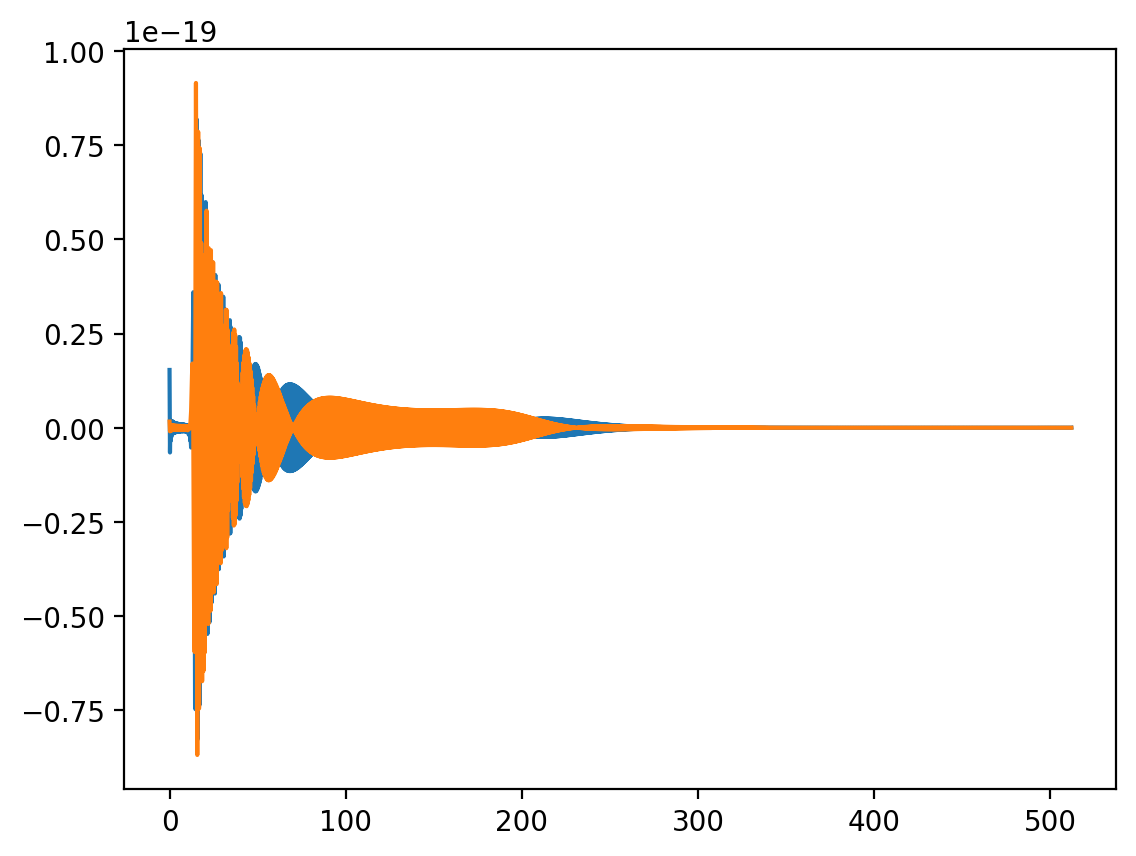

In [36]:
plt.plot(NR_model.freqs, hp)
plt.plot(NR_model.freqs, hc)
plt.show()

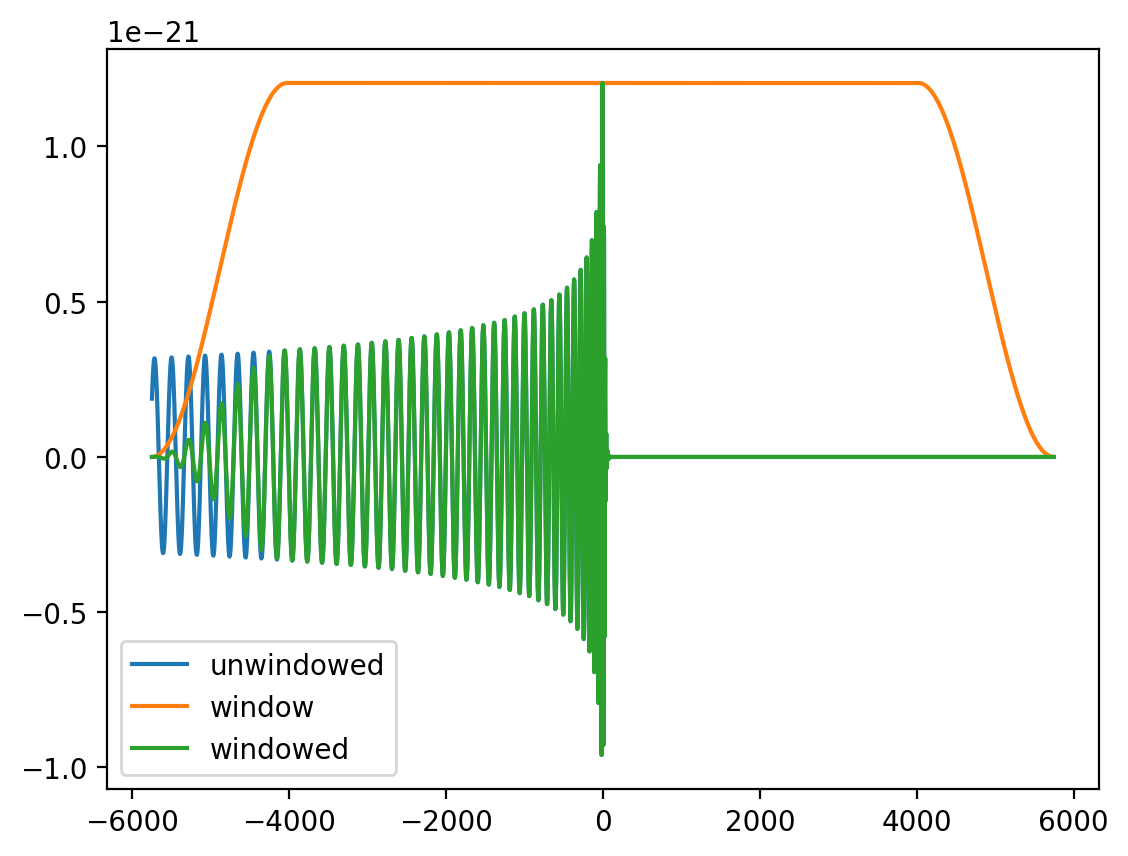

In [37]:
h, time_M = NR_model.gen_NRSurrogate_td(theta_ripple)
plt.plot(time_M, h, label="unwindowed")
plt.plot(time_M, NR_model.window * h.max(), label="window")
plt.plot(time_M, NR_model.window * h, label="windowed")
plt.legend()
plt.show()

In [38]:
hphc_jitted = jax.jit(NR_model.gen_NRSurrogate_hphc)
hphc_jitted(theta_ripple)

(Array([ 1.53242612e-20+0.00000000e+00j, -6.57466665e-21-8.64117482e-21j,
         1.87859594e-21+3.27325612e-21j, ...,
         9.09964836e-24+1.55177236e-25j, -9.09890412e-24-7.74423450e-26j,
         9.09885414e-24+0.00000000e+00j], dtype=complex128),
 Array([ 1.62765282e-21+0.00000000e+00j, -9.64855906e-22-6.26036461e-22j,
         6.68919183e-22+1.92933302e-22j, ...,
        -4.75524913e-24-6.67574724e-26j,  4.75513586e-24+3.35982180e-26j,
        -4.75474952e-24+0.00000000e+00j], dtype=complex128))

In [39]:
hp, hc = NR_model.gen_NRSurrogate_hphc(theta_ripple)

In [40]:
%timeit hphc_jitted(theta_ripple)

46.8 ms ± 879 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_hphc(NR_model.freqs[f_mask], theta_ripple, f_l)

In [42]:
PhenomD_jitted = jax.jit(IMRPhenomD.gen_IMRPhenomD_hphc)
PhenomD_jitted(NR_model.freqs[f_mask], theta_ripple, f_l)

(Array([ 4.81980736e-23+7.58262592e-23j, -3.47051367e-23+8.13686192e-23j,
        -8.47785084e-23+2.00173784e-23j, ...,
        -9.59372384e-28+4.90802988e-28j, -9.53334379e-28+4.87370297e-28j,
        -9.47335487e-28+4.83963447e-28j], dtype=complex128),
 Array([7.58262592e-23-4.81980736e-23j, 8.13686192e-23+3.47051367e-23j,
        2.00173784e-23+8.47785084e-23j, ...,
        4.90802988e-28+9.59372384e-28j, 4.87370297e-28+9.53334379e-28j,
        4.83963447e-28+9.47335487e-28j], dtype=complex128))

In [43]:
%timeit PhenomD_jitted(NR_model.freqs[f_mask], theta_ripple, f_l)

499 µs ± 7.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


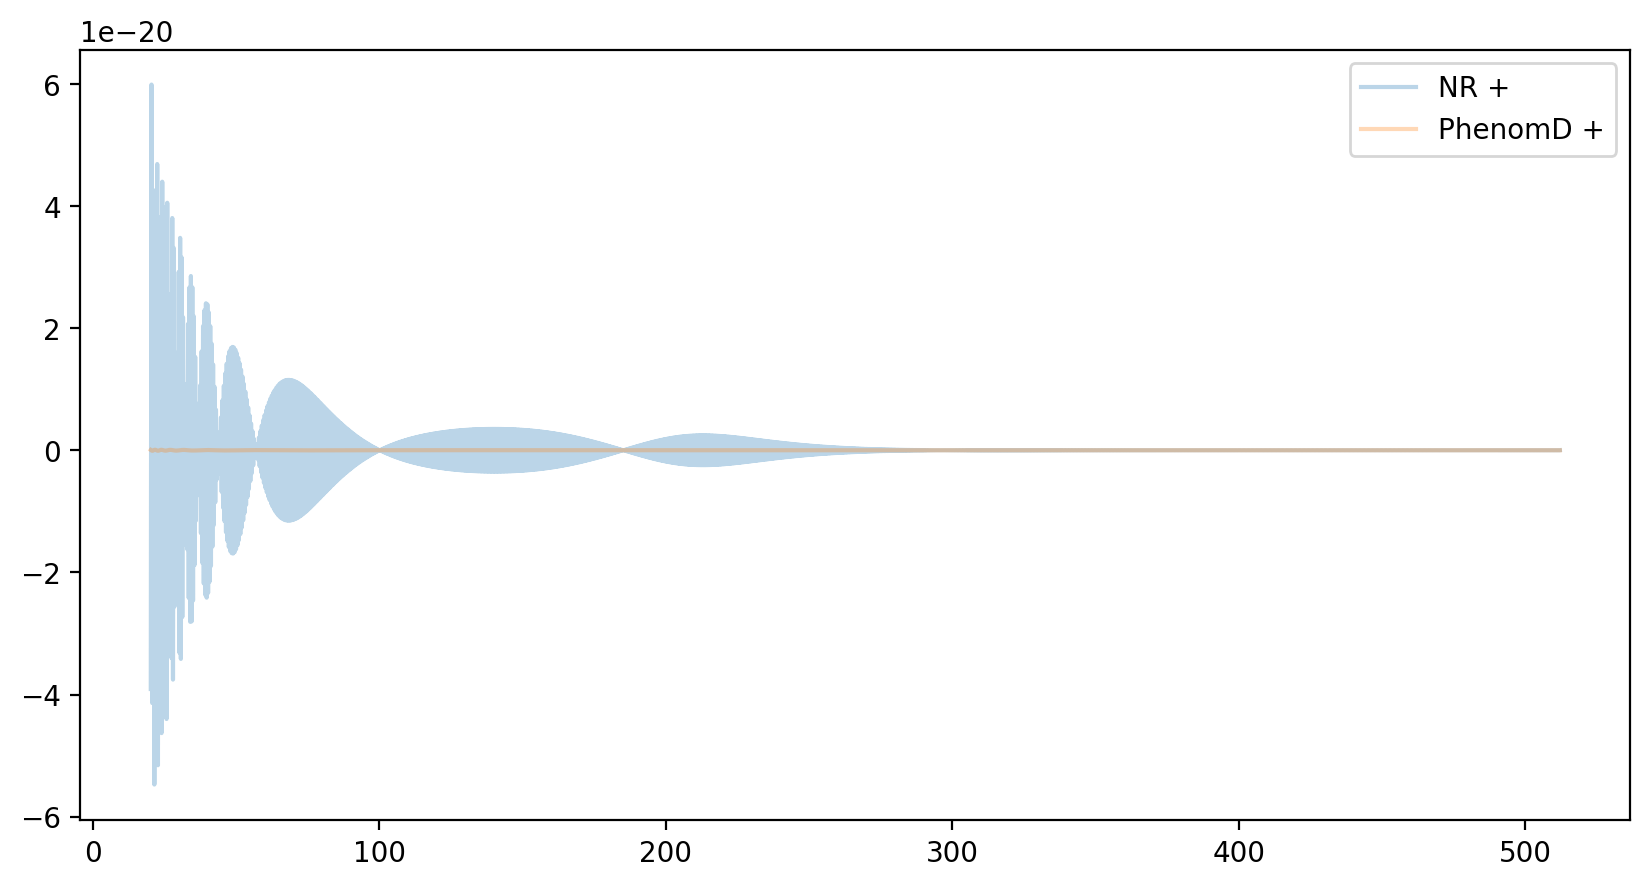

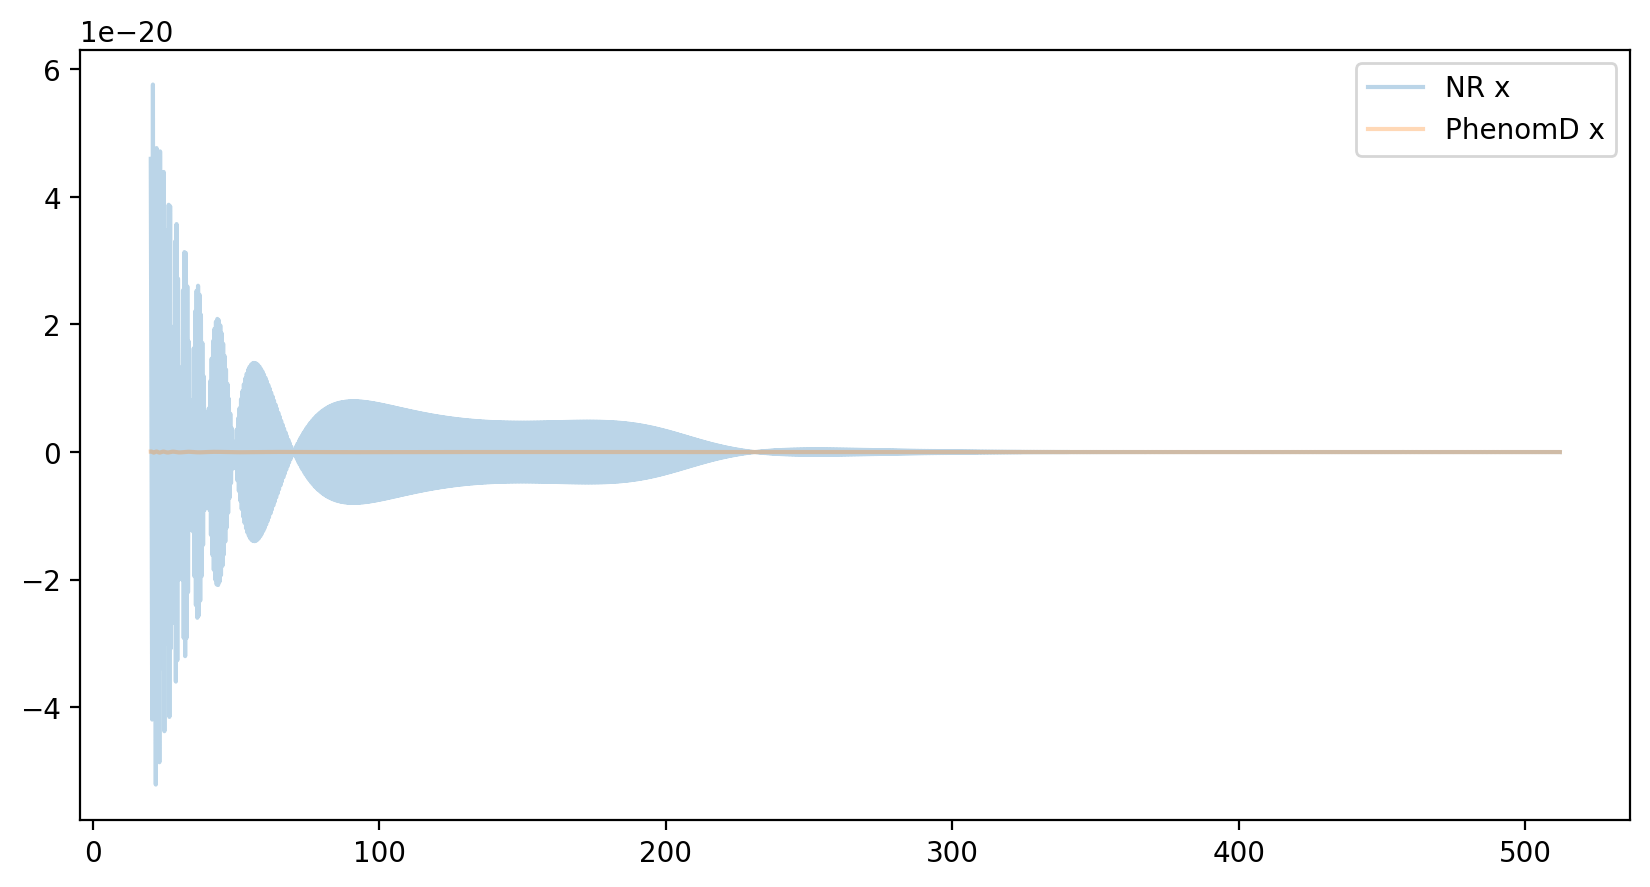

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(NR_model.freqs[f_mask], hp[f_mask], label="NR +", alpha=0.3)
plt.plot(NR_model.freqs[f_mask], hp_ripple, label="PhenomD +", alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(NR_model.freqs[f_mask], hc[f_mask], label="NR x", alpha=0.3)
plt.plot(NR_model.freqs[f_mask], hc_ripple, label="PhenomD x", alpha=0.3)
plt.legend()
plt.show()

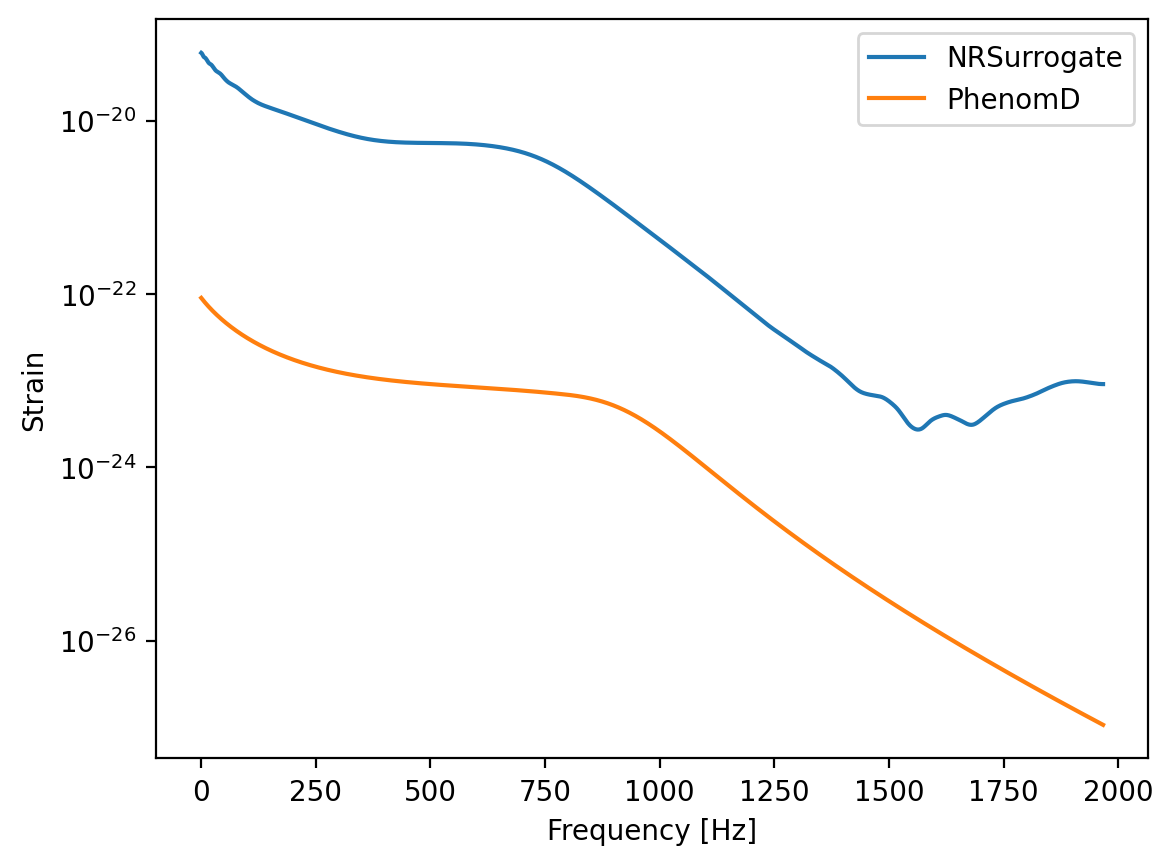

In [62]:
plt.semilogy(abs(hp[f_mask]), label="NRSurrogate")
plt.semilogy(abs(hp_ripple), label="PhenomD")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Strain")
plt.legend()
plt.show()